Import Libraries and Dependencies

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

import spacy
!python -q -m spacy download en

!pip -q install contractions
import contractions

!pip -q install emoji
import emoji

import re

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import os
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

!pip -q install wordcloud
from wordcloud import WordCloud

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 9.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 287 kB 7.1 MB/s 
     |████████████████████████████████| 106 kB 69.8 MB/s 
     |████████████████████████████████| 197 kB 8.6 MB/s 


# Download, and Unzip Dataset

[Dataset Link](https://www.kaggle.com/datasets/andrewmvd/cyberbullying-classification)

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d andrewmvd/cyberbullying-classification

  0% 0.00/2.82M [00:00<?, ?B/s]
100% 2.82M/2.82M [00:00<00:00, 168MB/s]


In [3]:
data_path= 'cyberbullying-classification'
!unzip 'cyberbullying-classification.zip' -d {data_path}

Archive:  cyberbullying-classification.zip
  inflating: cyberbullying-classification/cyberbullying_tweets.csv  


# Load & Explore the Data

In [4]:
df= pd.read_csv(os.path.join(data_path, 'cyberbullying_tweets.csv'))
df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [5]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [6]:
df.drop(df[df['cyberbullying_type']=='other_cyberbullying'].index, inplace=True)

df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [7]:
df= df.drop_duplicates('tweet_text')

df

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


## Visualizing the Wordcloud

In [8]:
text= ' '.join(df['tweet_text'])

(-0.5, 799.5, 499.5, -0.5)

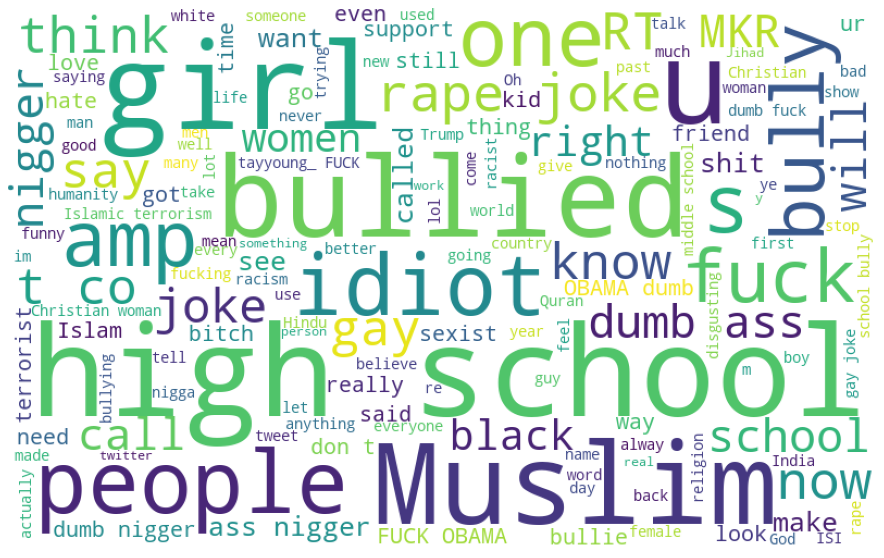

In [9]:
plt.figure(figsize=(16,10))
wc= WordCloud(width= 800, height= 500, max_words=150, background_color='white').generate(text)
plt.imshow(wc)
plt.axis('off')

#**Preprocessing**

## Checking Null Value

In [10]:
df.isna().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

## Handling Outlier

In [11]:
text_len = []
for text in df['tweet_text']:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [12]:
df['text_len']= text_len

df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,tweet_text,cyberbullying_type,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,9
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,14
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,9
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,18
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,18


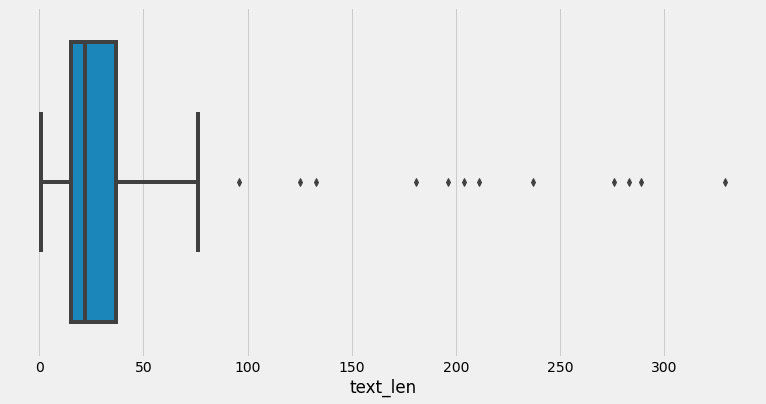

In [13]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['text_len'], whis=2)

In [14]:
df= df[df['text_len'] > 3]
df= df[df['text_len'] < 100]

df

,tweet_text,cyberbullying_type,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,9
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,14
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,9
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,18
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,18
...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,42
47688,Turner did not withhold his disappointment. Tu...,ethnicity,45
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,20
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,15


## One Hot Encoding

In [15]:
cyberbullying_type= pd.get_dummies(df['cyberbullying_type'])
df_ohe= pd.concat([df['tweet_text'], cyberbullying_type], axis=1)

df_ohe

,tweet_text,age,ethnicity,gender,not_cyberbullying,religion
0,"In other words #katandandre, your food was cra...",0,0,0,1,0
1,Why is #aussietv so white? #MKR #theblock #ImA...,0,0,0,1,0
2,@XochitlSuckkks a classy whore? Or more red ve...,0,0,0,1,0
3,"@Jason_Gio meh. :P thanks for the heads up, b...",0,0,0,1,0
4,@RudhoeEnglish This is an ISIS account pretend...,0,0,0,1,0
...,...,...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",0,1,0,0,0
47688,Turner did not withhold his disappointment. Tu...,0,1,0,0,0
47689,I swear to God. This dumb nigger bitch. I have...,0,1,0,0,0
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,0,1,0,0,0


## Train Val Split

In [16]:
X= df_ohe['tweet_text']
y= df_ohe.drop('tweet_text', axis=1)

x_train, x_val, y_train, y_val= train_test_split(X, y, test_size=0.2)

len(x_train), len(x_val)

(31328, 7833)

## Contraction to Expansion

In [17]:
preprocessed_x_train= x_train.map(lambda x: contractions.fix(x.lower()))
preprocessed_x_val= x_val.map(lambda x: contractions.fix(x.lower()))

preprocessed_x_train.head()

42815    rt @rarebloodline: rt @mikesimswalker: rt @sam...
18283    @imrankhanpti @officialdgispr is not he a musl...
20527    @abunaseeha2 @ansarulshareeah yeah, this is ba...
37953    spreading “kindness” and “blm” when they thems...
37619    taunt her, a dark, bully high school romance b...
Name: tweet_text, dtype: object

## Stripping Emojis

In [18]:
preprocessed_x_train= preprocessed_x_train.map(lambda x: emoji.replace_emoji(x, replace=''))
preprocessed_x_val= preprocessed_x_val.map(lambda x: emoji.replace_emoji(x, replace=''))

preprocessed_x_train.head()

42815    rt @rarebloodline: rt @mikesimswalker: rt @sam...
18283    @imrankhanpti @officialdgispr is not he a musl...
20527    @abunaseeha2 @ansarulshareeah yeah, this is ba...
37953    spreading “kindness” and “blm” when they thems...
37619    taunt her, a dark, bully high school romance b...
Name: tweet_text, dtype: object

## Clean Hashtags

In [19]:
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

preprocessed_x_train= preprocessed_x_train.map(clean_hashtags)
preprocessed_x_val= preprocessed_x_val.map(clean_hashtags)

preprocessed_x_train.head()

42815    rt @rarebloodline: rt @mikesimswalker: rt @sam...
18283    @imrankhanpti @officialdgispr is not he a musl...
20527    @abunaseeha2 @ansarulshareeah yeah, this is ba...
37953    spreading “kindness” and “blm” when they thems...
37619    taunt her, a dark, bully high school romance b...
Name: tweet_text, dtype: object

## Remove Mentions and Links

In [20]:
preprocessed_x_train= preprocessed_x_train.map(lambda x: re.sub(r'(?:\@|https?\://)\S+', '', x))
preprocessed_x_val= preprocessed_x_val.map(lambda x: re.sub(r'(?:\@|https?\://)\S+', '', x))

preprocessed_x_train.head()

42815    rt  rt  rt   fuck you dumb nigger!!!! jags suc...
18283      is not he a muslim is not a pakistani? blood...
20527      yeah, this is bad. they should take isis exa...
37953    spreading “kindness” and “blm” when they thems...
37619    taunt her, a dark, bully high school romance b...
Name: tweet_text, dtype: object

## Remove Extra Spaces

In [21]:
preprocessed_x_train= preprocessed_x_train.map(lambda x: re.sub('\s\s+', ' ', x))
preprocessed_x_val= preprocessed_x_val.map(lambda x: re.sub('\s\s+', ' ', x))

preprocessed_x_train.head()

42815    rt rt rt fuck you dumb nigger!!!! jags suck fu...
18283     is not he a muslim is not a pakistani? bloody...
20527     yeah, this is bad. they should take isis exam...
37953    spreading “kindness” and “blm” when they thems...
37619    taunt her, a dark, bully high school romance b...
Name: tweet_text, dtype: object

## Lemmatization

In [22]:
nlp= spacy.load('en_core_web_sm')

def make_to_base(x):
    doc= nlp(str(x))
    x_list= [token.lemma_ for token in doc]
        
    return ' '.join(x_list)

Cell di bawah memakan waktu 5 menit pada google colabs GPU

In [24]:
preprocessed_x_train= preprocessed_x_train.map(make_to_base)
preprocessed_x_val= preprocessed_x_val.map(make_to_base)

preprocessed_x_train.head()

42815    rt rt rt fuck you dumb nigger ! ! ! ! jag suck...
18283      be not he a muslim be not a pakistani ? bloo...
20527      yeah , this be bad . they should take isis e...
37953    spread " kindness " and " blm " when they them...
37619    taunt she , a dark , bully high school romance...
Name: tweet_text, dtype: object

## Tokenizing

In [26]:
tokenizer = Tokenizer(oov_token='-')

tokenizer.fit_on_texts(preprocessed_x_train)
tokenizer.fit_on_texts(preprocessed_x_val)

preprocessed_x_train = tokenizer.texts_to_sequences(preprocessed_x_train)
preprocessed_x_val = tokenizer.texts_to_sequences(preprocessed_x_val)

## Padding

In [27]:
words_len=  50

padded_preprocessed_x_train= pad_sequences(preprocessed_x_train, maxlen=words_len, padding='post', truncating = 'post')
padded_preprocessed_x_val= pad_sequences(preprocessed_x_val, maxlen=words_len, padding='post', truncating = 'post')

padded_preprocessed_x_train

array([[   55,    55,    55, ...,     0,     0,     0],
       [    2,     9,    26, ...,  1566,     0,     0],
       [  266,    24,     2, ...,     0,     0,     0],
       ...,
       [    3,    12,     9, ...,     0,     0,     0],
       [30723,   109,     3, ..., 14211,  2667,    86],
       [   12,  2729,  2119, ...,     0,     0,     0]], dtype=int32)

# Training

In [28]:
EMBEDDING_DIM= 256

model = keras.models.Sequential([
    keras.layers.Embedding(len(tokenizer.word_index)+1, EMBEDDING_DIM, input_length=words_len),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.Dropout(0.25),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dropout(0.25),
    keras.layers.LSTM(256),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [29]:
reduce_lr= keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor= 0.75, patience=1, min_lr=1e-5, min_delta=0.01)

history = model.fit(padded_preprocessed_x_train, y_train, epochs=10, 
                    validation_data=(padded_preprocessed_x_val, y_val))

Epoch 1/10
979/979 [==============================] - 28s 20ms/step - loss: 0.9443 - accuracy: 0.5460 - val_loss: 0.7857 - val_accuracy: 0.6090
Epoch 2/10
979/979 [==============================] - 18s 19ms/step - loss: 0.6152 - accuracy: 0.7382 - val_loss: 0.3466 - val_accuracy: 0.8914
Epoch 3/10
979/979 [==============================] - 18s 18ms/step - loss: 0.2814 - accuracy: 0.9177 - val_loss: 0.2780 - val_accuracy: 0.9164
Epoch 4/10
979/979 [==============================] - 18s 18ms/step - loss: 0.2132 - accuracy: 0.9380 - val_loss: 0.2587 - val_accuracy: 0.9173
Epoch 5/10
979/979 [==============================] - 19s 19ms/step - loss: 0.1715 - accuracy: 0.9527 - val_loss: 0.2522 - val_accuracy: 0.9226
Epoch 6/10
979/979 [==============================] - 19s 19ms/step - loss: 0.1426 - accuracy: 0.9618 - val_loss: 0.2709 - val_accuracy: 0.9256
Epoch 7/10
979/979 [==============================] - 23s 23ms/step - loss: 0.1190 - accuracy: 0.9686 - val_loss: 0.2738 - val_accuracy:

# Visualization of Loss and Accuracy During Training and Validation.

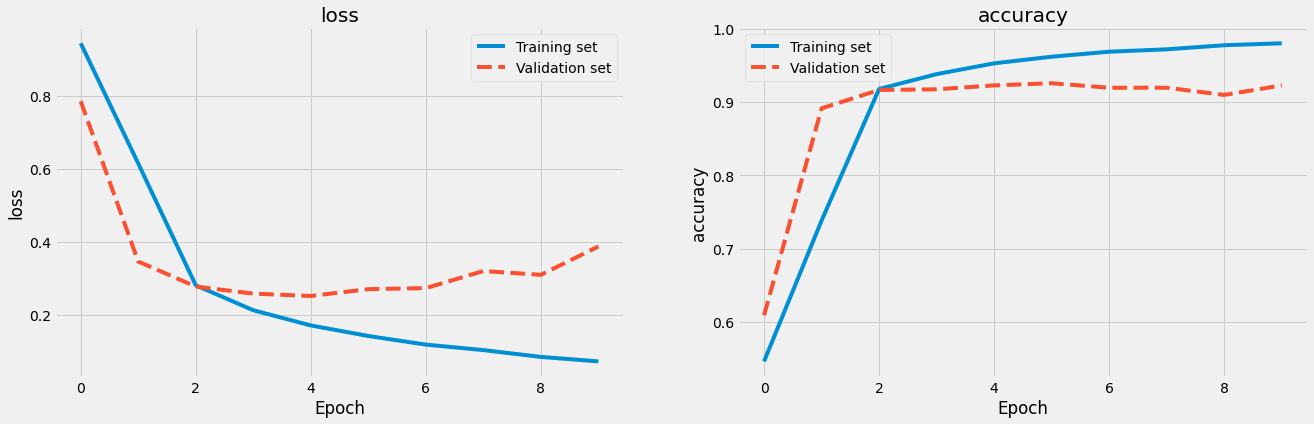

In [30]:
plt.figure(figsize=(20, 6))

for idx, i in enumerate(['loss', 'accuracy']):
    plt.subplot(1, 2, idx+1)
    plt.title(i)
    plt.xlabel('Epoch')
    plt.ylabel(i)
    plt.plot(history.history[i], label='Training set')
    plt.plot(history.history[f'val_{i}'], label='Validation set', linestyle='--')
    plt.legend()

plt.show()

# Predict a Cyberbullying

In [54]:
labels= df_ohe.columns[1:]
labels

Index(['age', 'ethnicity', 'gender', 'not_cyberbullying', 'religion'], dtype='object')

In [55]:
text= ['go to kitchen you fucking girl']

x= tokenizer.texts_to_sequences(text)
x= pad_sequences(x, maxlen=words_len, padding='post', truncating = 'post')

pred= model.predict(x)

In [56]:
labels[np.argmax(pred)]

'gender'